In [9]:
# !pip install torch-explain

In [21]:
import torch
import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from torch_explain.nn.concepts import ConceptReasoningLayer, ConceptEmbedding
import torch.nn.functional as F
import numpy as np

In [22]:
x, c, y = datasets.xor(80000)
x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(x, c, y, test_size=0.33, random_state=42)

### Transformation necessary for DCR
y_train = F.one_hot(y_train.long().ravel()).float()
y_test = F.one_hot(y_test.long().ravel()).float()

You define a **task predictor** (the part of the network that is responsible of the transformation `concepts -> predictions`, in our case the **DCR**) and a concept encoder using a **concept embedding layer** (that goes `inputs -> concepts`)

In [23]:
embedding_size = 8 # Each concept will be made of 8 embeddings
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[1], out_features=10),
    torch.nn.LeakyReLU(),
    ConceptEmbedding(in_features=10, n_concepts=c.shape[1], emb_size=embedding_size),
)

In [24]:
task_predictor = ConceptReasoningLayer(embedding_size, y_train.shape[1])
model = torch.nn.Sequential(concept_encoder, task_predictor)

### **TRAINING**

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_form = torch.nn.BCELoss()
n_epochs = 41
model.train()
train_losses, train_correct = 0, 0
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # generate concept and task predictions
    c_emb, c_pred = concept_encoder(x_train)
    y_pred = task_predictor(c_emb, c_pred)

    # compute loss
    concept_loss = loss_form(c_pred, c_train)
    task_loss = loss_form(y_pred, y_train)
    loss = concept_loss + 0.5*task_loss

    loss.backward()
    optimizer.step()
    
    train_losses += loss.item()
    train_correct += (y_pred.argmax(1) == y_train.argmax(1)).sum().item()
    
    if epoch+1 % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {train_losses/len(x_train)}, Train Accuracy: {train_correct/len(x_train)}")


### **EVALUATION**

After training the model, we can evaluate its performance on the test set

In [18]:
c_emb, c_pred = concept_encoder.forward(x_test)
y_pred = task_predictor(c_emb, c_pred)

concept_accuracy = accuracy_score(c_test, c_pred > 0.5)
task_accuracy = accuracy_score(y_test, y_pred > 0.5)

print(f'CONCEPT ACCURACY: {concept_accuracy:.2f}')
print(f'TASK ACCURACY: {task_accuracy:.2f}')

CONCEPT ACCURACY: 0.47
TASK ACCURACY: 0.30


In [19]:
local_explanations = task_predictor.explain(c_emb, c_pred, 'local')
local_explanations[0]

{'class': -1, 'explanation': '', 'attention': []}

In [20]:
task_predictor.explain(c_emb, c_pred, 'global')

[{'class': 'y_0', 'explanation': '~c_0 & ~c_1', 'count': 14705}]

## **My test for training a Decision Tree**

### 1. The following part is made "by hand". ALL the reasoning is transparent in each cell and it is made ad hoc for the XOR datase

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

In [19]:
# I HAVE TO GET EVERYTHING FROM THE TRAINING SET
c_emb, c_pred = concept_encoder.forward(x_train)
y_pred_dt, sign_attn_dt, filter_attn_dt = task_predictor.forward(c_emb, c_pred, return_attn=True)

# To get the sign terms (FUTURE WORK IMPEMENT A BOOL ABLE TO TELL ME TO RETURN DIRECTLY SIGN TERMS AND WHAT I NEED)
from torch_explain.nn.semantics import GodelTNorm

logic = GodelTNorm()
values_dt = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
sign_terms_dt = logic.iff_pair(sign_attn_dt, values_dt)

In [20]:
# Checking the shapes

print(f'y_pred_dt: {y_pred_dt.shape}')
print(f'sign_attn_dt: {sign_attn_dt.shape}')
print(f'filter_attn_dt: {filter_attn_dt.shape}')
# y_pred = (#samples, #classes)
# sign_attn_dt = filter_attn_dt = (#samples, #concepts, #classes)

y_pred_dt: torch.Size([2010, 2])
sign_attn_dt: torch.Size([2010, 2, 2])
filter_attn_dt: torch.Size([2010, 2, 2])


In [21]:
sign_concept_0 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,0,:]])
sign_concept_1 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,1,:]])
filter_concept_0 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,0,:]])
filter_concept_1 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,1,:]])

final_features = np.hstack((sign_concept_0, filter_concept_0, sign_concept_1, filter_concept_1))


In [22]:
# Creation of the pd dataframe
import pandas as pd

names = ['sign_c0_y0', 'sign_c0_y1', 'filter_c0_y0', 'filter_c0_y1', 'sign_c1_y0', 'sign_c1_y1', 'filter_c1_y0', 'filter_c1_y1']
df = pd.DataFrame(final_features, columns=names)

# Stampa il DataFrame
df.head()

,sign_c0_y0,sign_c0_y1,filter_c0_y0,filter_c0_y1,sign_c1_y0,sign_c1_y1,filter_c1_y0,filter_c1_y1
0,1.023437e-02,9.999691e-01,1.0,1.0,1.371609e-04,0.999863,1.0,1.0
1,1.439282e-05,9.999856e-01,1.0,1.0,9.935637e-01,1.000000,1.0,1.0
2,9.999964e-01,3.576279e-06,1.0,1.0,9.999956e-01,0.999213,1.0,1.0
3,6.850147e-16,1.000000e+00,1.0,1.0,8.085757e-13,1.000000,1.0,1.0
4,1.000000e+00,4.613880e-09,1.0,1.0,1.000000e+00,0.006074,1.0,1.0


In [23]:
# Target labels

# Remember that y_pred_dt>0.5 will return an np.array of booleans of dimension (n_samples, n_classes)
# the single prediction willbe then a onehot encoding of the right prediction (True if belongs to class_{i} where i is the position in the prediction vector)
# EXAMPLE: pred = [False, True] --> Class_1
y_dt = ['False' if pred[0] else 'True' for pred in y_pred_dt>0.5]
dt.fit(df, y_dt)

DecisionTreeClassifier()

2024-06-14 12:33:37,122 - matplotlib - DEBUG - matplotlib data path: c:\Users\robit\.conda\envs\explandtrustAI\Lib\site-packages\matplotlib\mpl-data
2024-06-14 12:33:37,128 - matplotlib - DEBUG - CONFIGDIR=C:\Users\robit\.matplotlib
2024-06-14 12:33:37,130 - matplotlib - DEBUG - interactive is False
2024-06-14 12:33:37,131 - matplotlib - DEBUG - platform is win32
2024-06-14 12:33:37,182 - matplotlib - DEBUG - CACHEDIR=C:\Users\robit\.matplotlib
2024-06-14 12:33:37,184 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\robit\.matplotlib\fontlist-v330.json
2024-06-14 12:33:37,387 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-14 12:33:37,388 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-14 12:33:37,392 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0

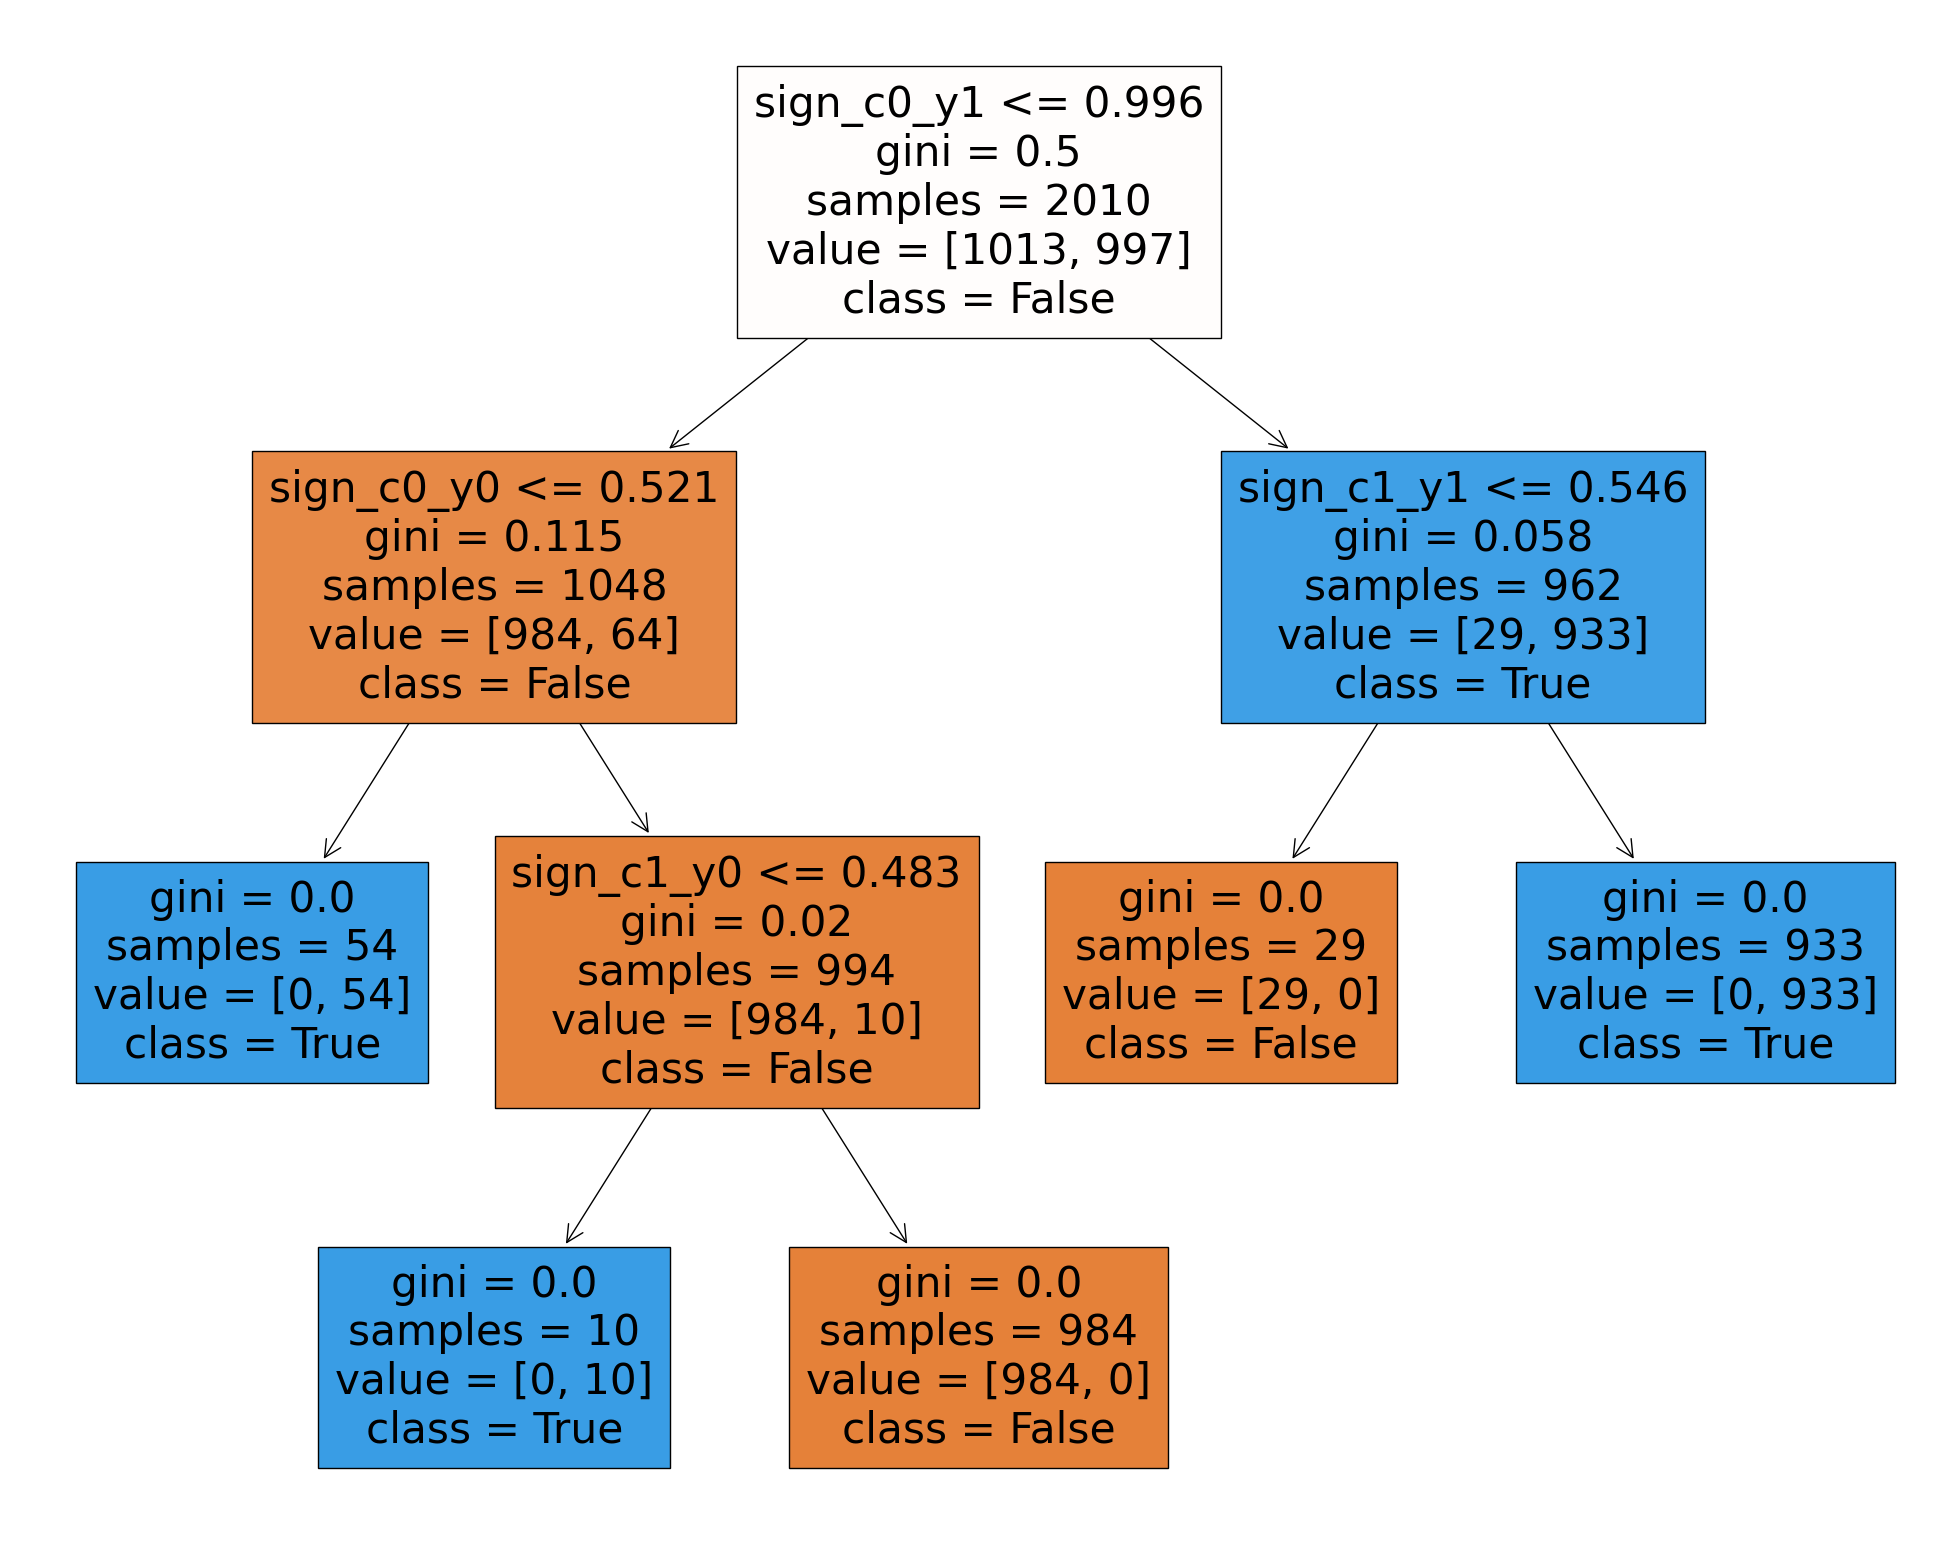

In [24]:
# Let's plot the result

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt, feature_names=df.columns, class_names=['False', 'True'], filled=True)
plt.show()

In [25]:
# Evaluation of accuracy score on TEST SET

c_emb_test, c_pred_test = concept_encoder.forward(x_test)
y_pred_dt_test, sign_attn_dt_test, filter_attn_dt_test = task_predictor.forward(c_emb_test, c_pred_test, return_attn=True)

values_test = c_pred_test.unsqueeze(-1).repeat(1, 1, len(y_pred_dt_test[1]))
sign_terms_dt_test = logic.iff_pair(sign_attn_dt_test, values_test)

In [26]:
sign_concept_0_test = np.vstack([sign.detach().numpy() for sign in sign_terms_dt_test[:,0,:]])
sign_concept_1_test = np.vstack([sign.detach().numpy() for sign in sign_terms_dt_test[:,1,:]])
filter_concept_0_test = np.vstack([f.detach().numpy() for f in filter_attn_dt_test[:,0,:]])
filter_concept_1_test = np.vstack([f.detach().numpy() for f in filter_attn_dt_test[:,1,:]])

final_features_test = np.hstack((sign_concept_0_test, filter_concept_0_test, sign_concept_1_test, filter_concept_1_test))
df_test = pd.DataFrame(final_features_test, columns=names)

In [28]:
y_predicted = dt.predict(df_test)
y_test_dt = ['False' if pred[0] else 'True' for pred in y_test]
accuracy_score(y_test_dt, y_predicted)

0.996969696969697

Now I train 2 different DTs, one for each class (y0, y1)

In [29]:
# Crea un DataFrame con solo le colonne y0
df_y0 = df.filter(like='y0')

# Crea un DataFrame con solo le colonne y1
df_y1 = df.filter(like='y1')

In [30]:
y_dt0 = [True if pred[0] else False for pred in y_pred_dt>0.5] # If pred[0] is True -> it belongs to class y0
y_dt1 = [True if pred[1] else False for pred in y_pred_dt>0.5] # If pred[1] is True -> it belongs to class y1

clf0 = DecisionTreeClassifier()
clf0.fit(df_y0, y_dt0)

clf1 = DecisionTreeClassifier()
clf1.fit(df_y1, y_dt1)

DecisionTreeClassifier()

2024-06-14 12:35:12,621 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=30.51448070697348.
2024-06-14 12:35:12,622 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\robit\\.conda\\envs\\explandtrustAI\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-06-14 12:35:12,622 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\robit\\.conda\\envs\\explandtrustAI\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-06-14 12:35:12,623 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\robit\\.conda\\envs\\explandtrustAI\\Lib\\site-packages\\matplot

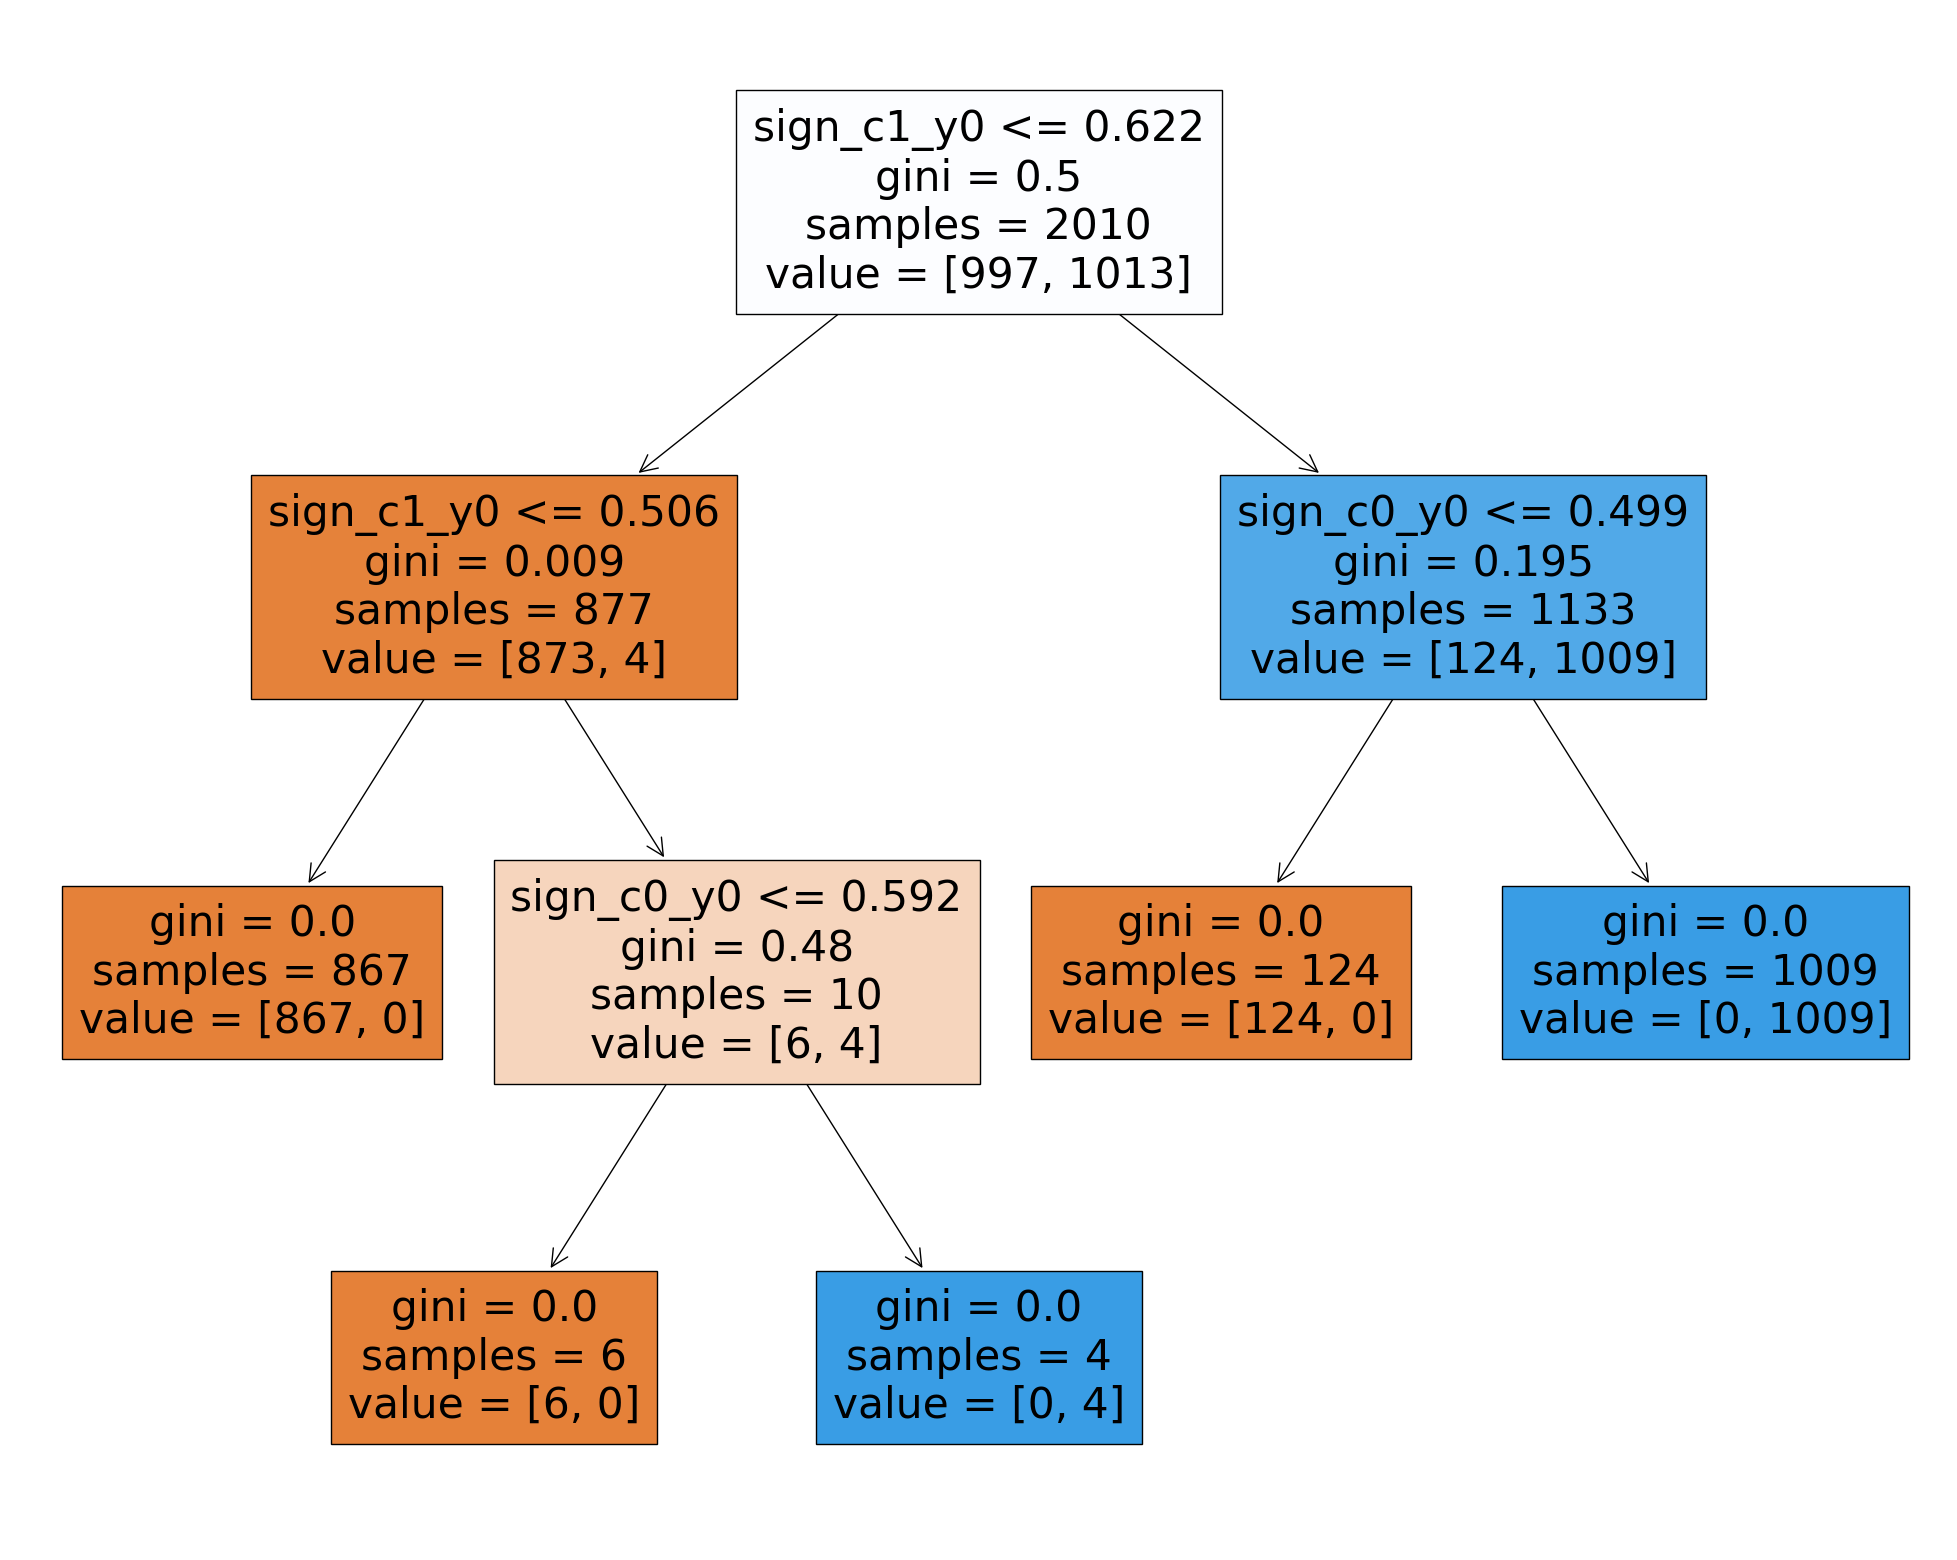

In [31]:
# Plot for Y0

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf0, feature_names=df_y0.columns, filled=True)
plt.show()

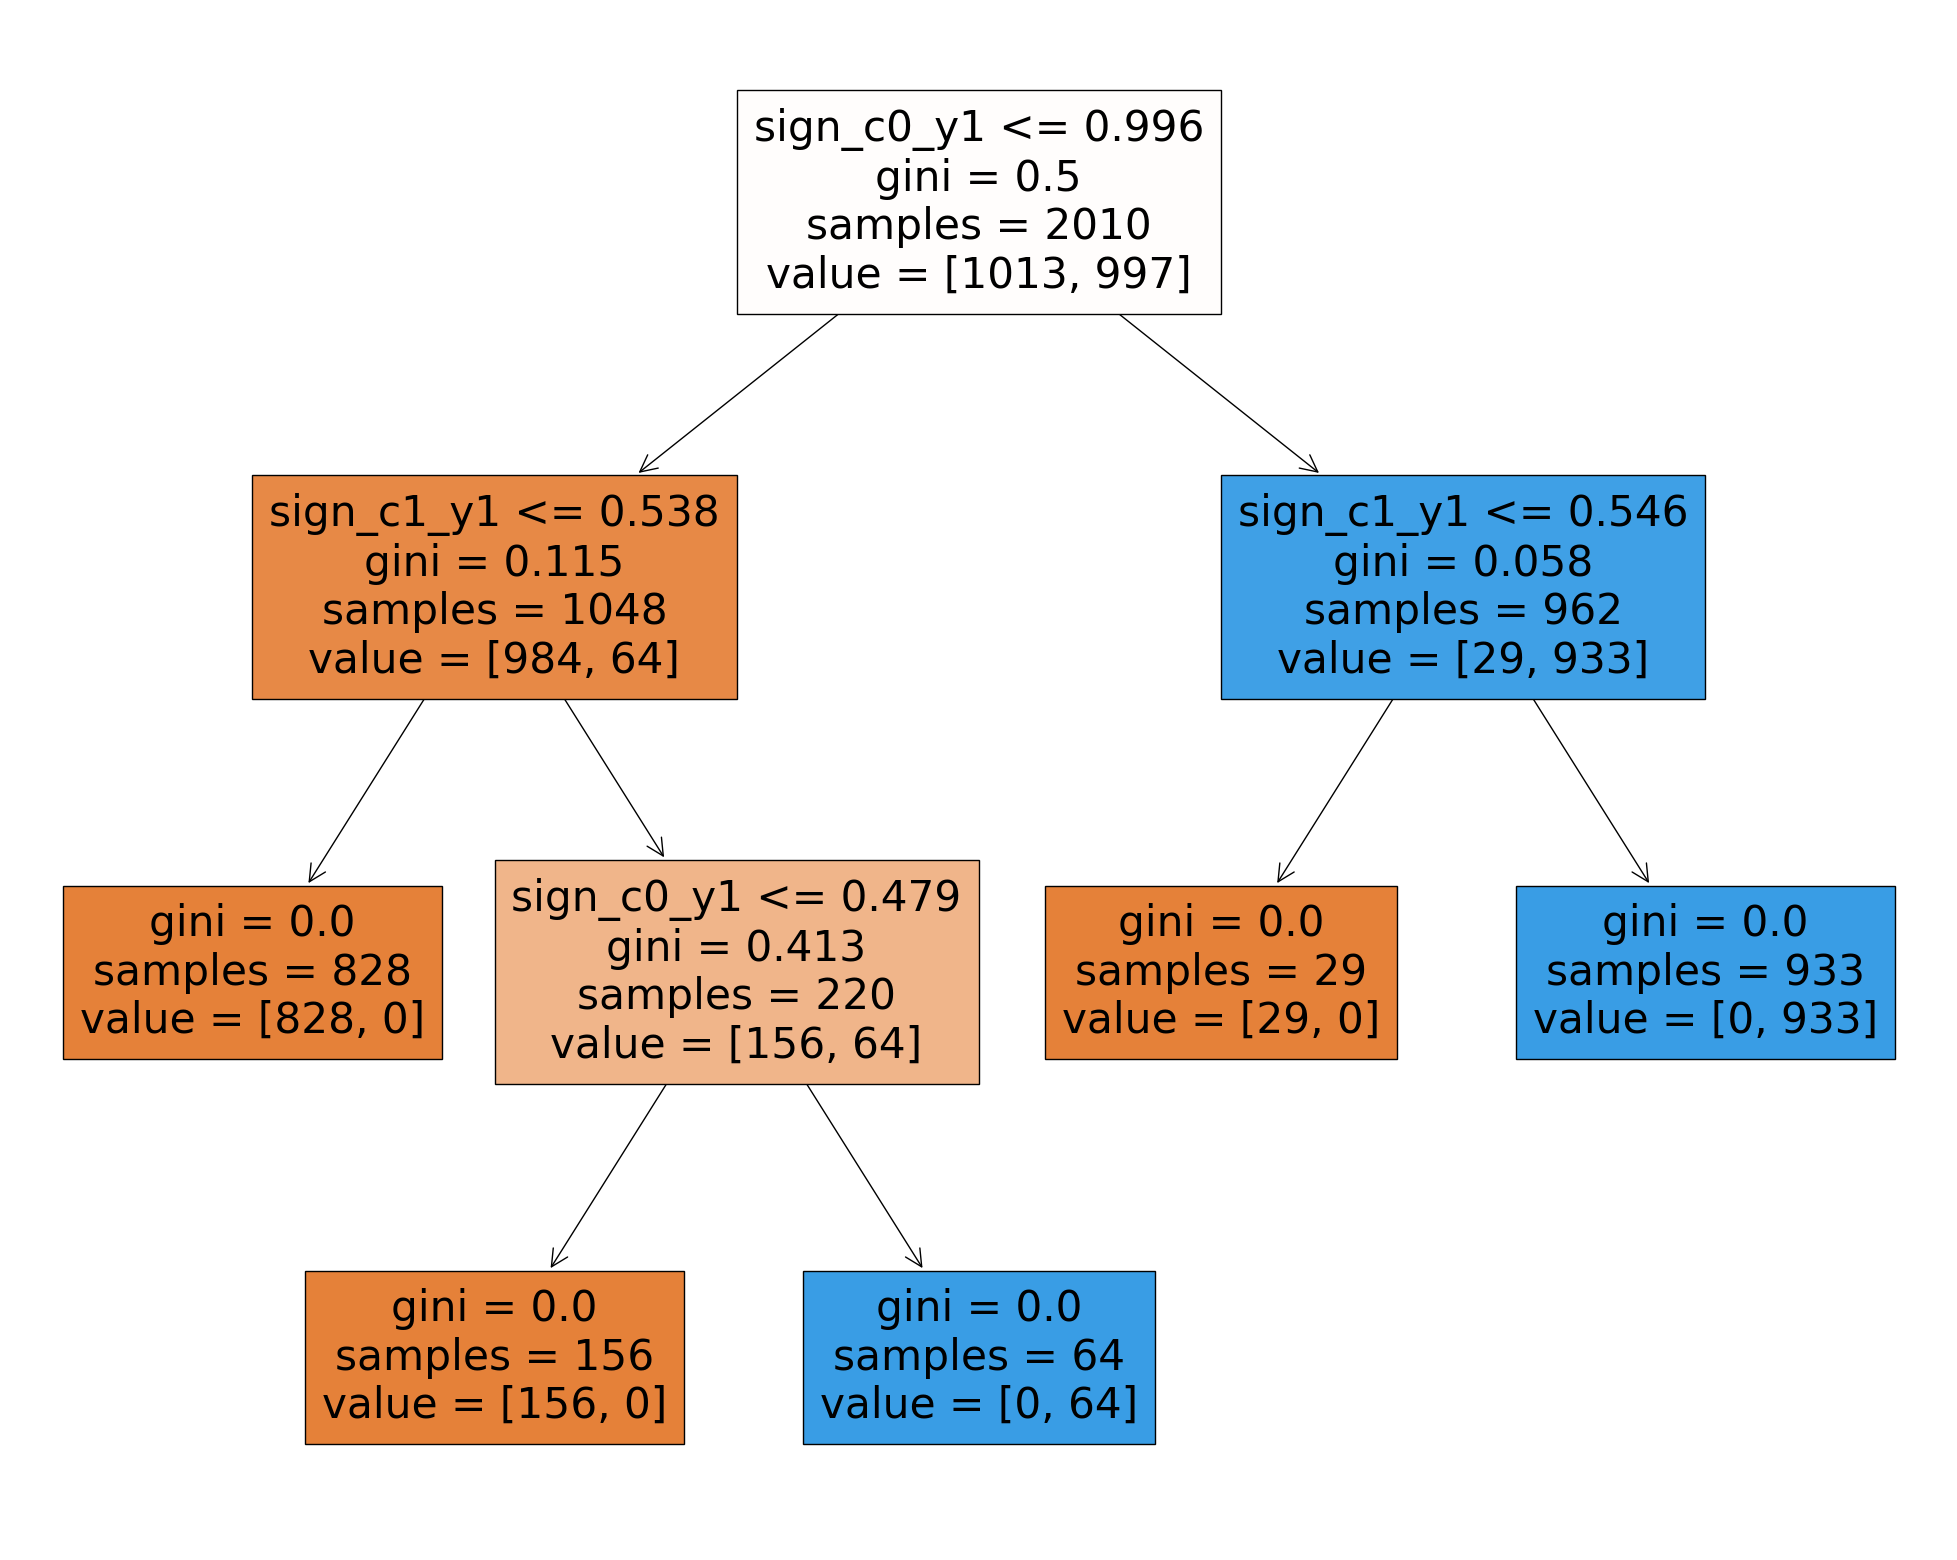

In [32]:
# Plot for Y1

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf1, feature_names=df_y1.columns, filled=True)
plt.show()

### 2. This part uses the function 'explain_with_DT' that you can find in decision_tree_explain.py. It is more general and should work for every kind of dataset you provide to it

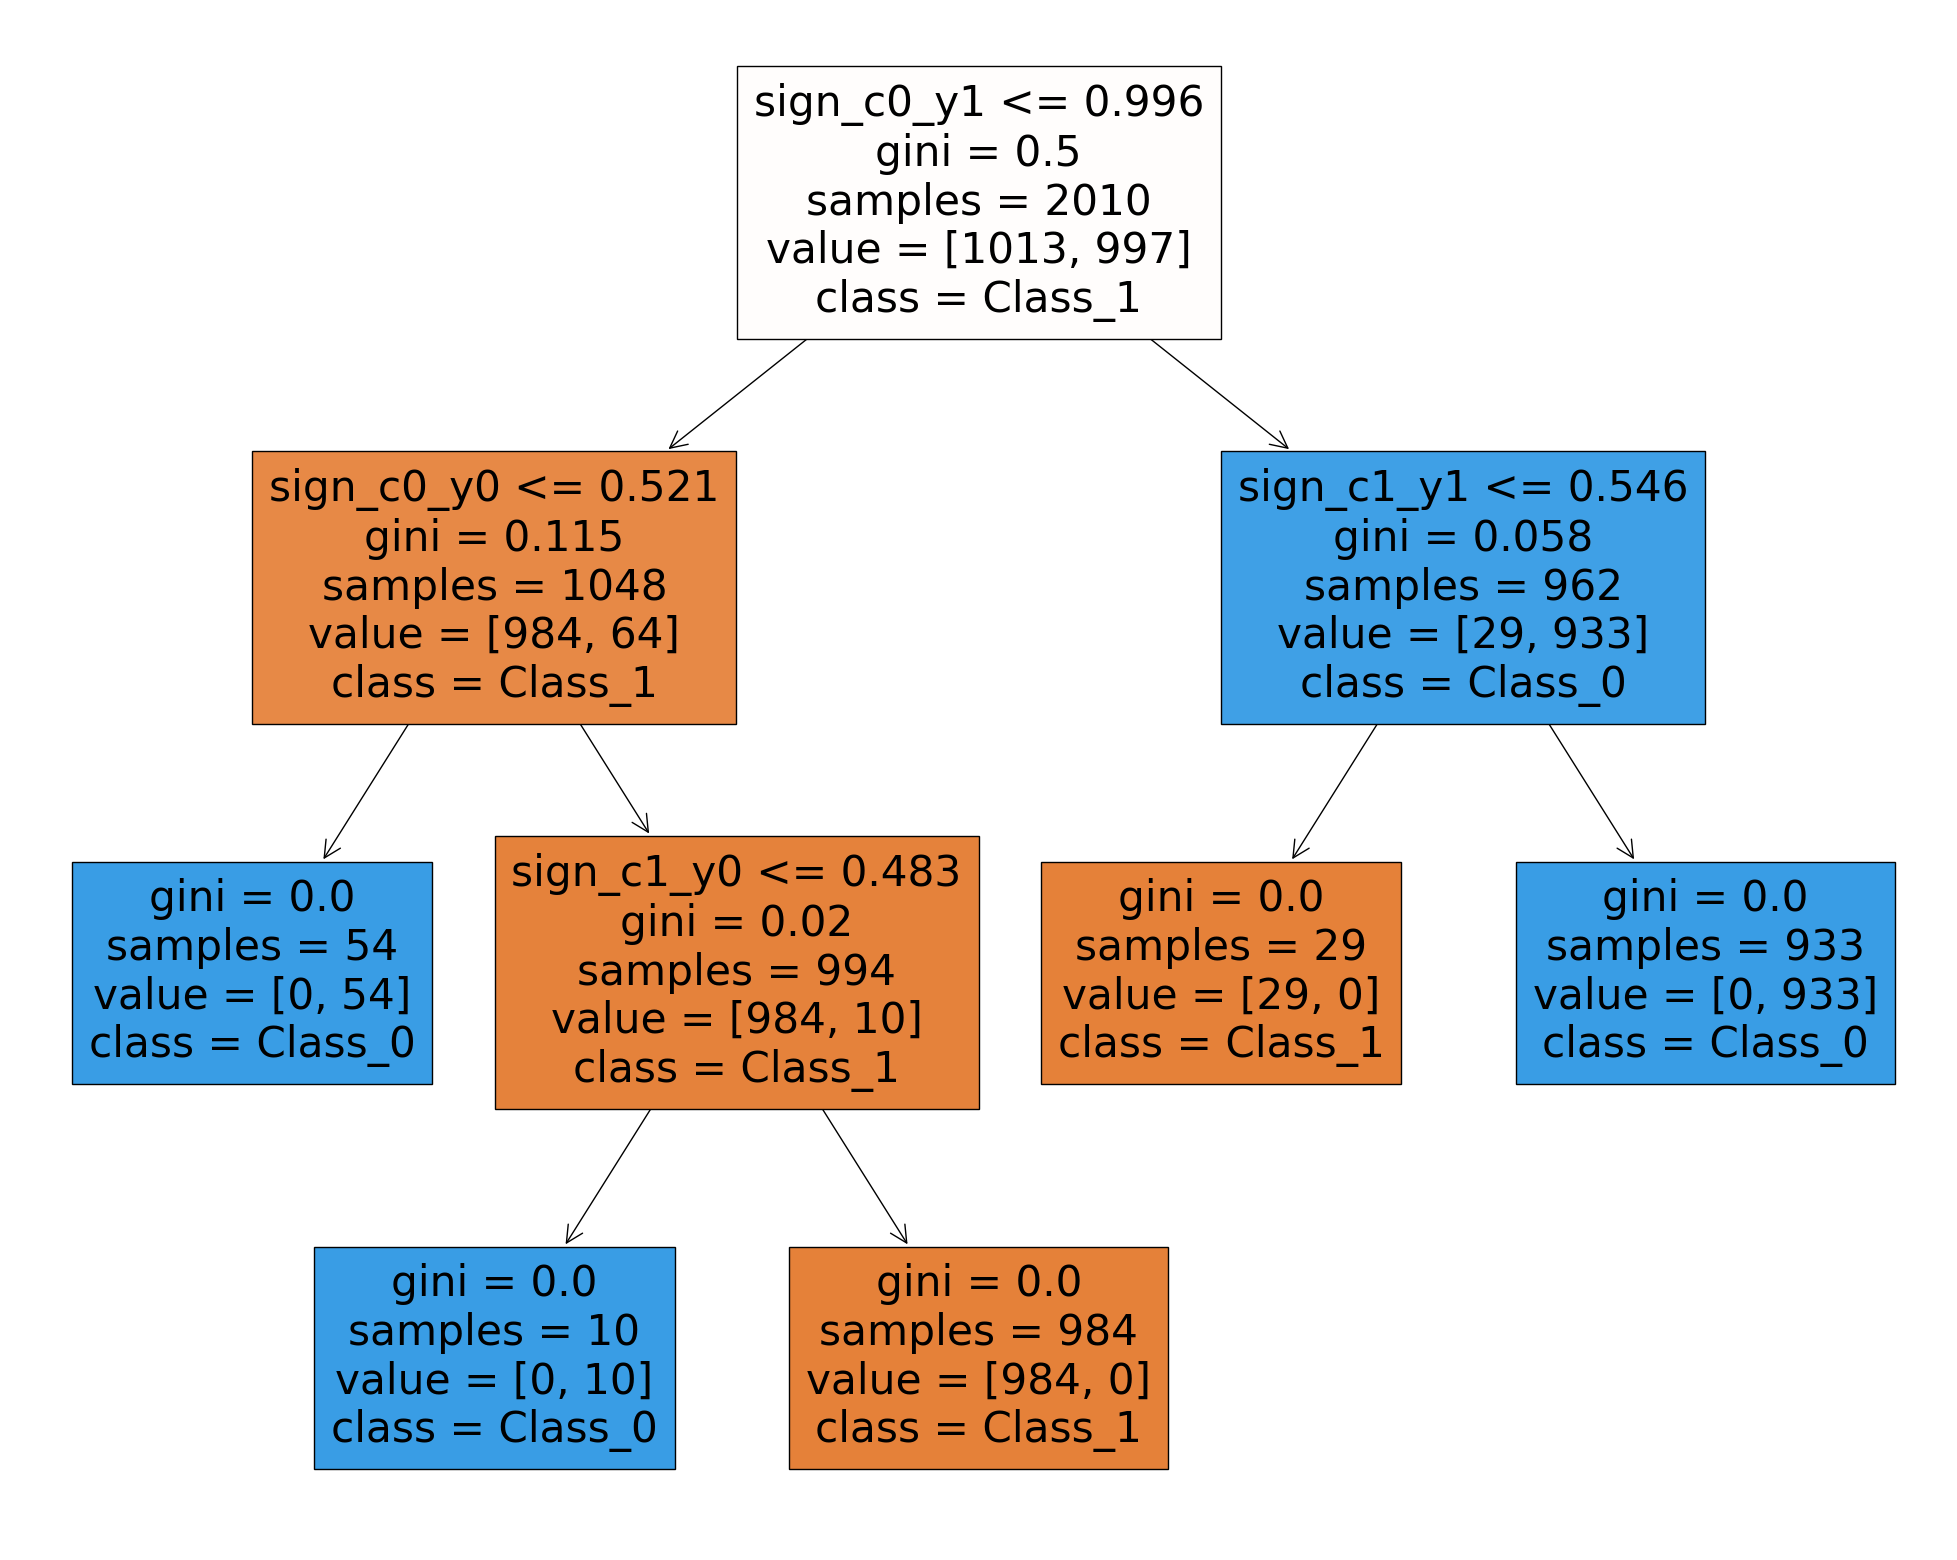

In [33]:
from decision_tree_explain import explain_with_DT

# 1 DT for both classes
clf_funct = explain_with_DT(x_train, concept_encoder, task_predictor)

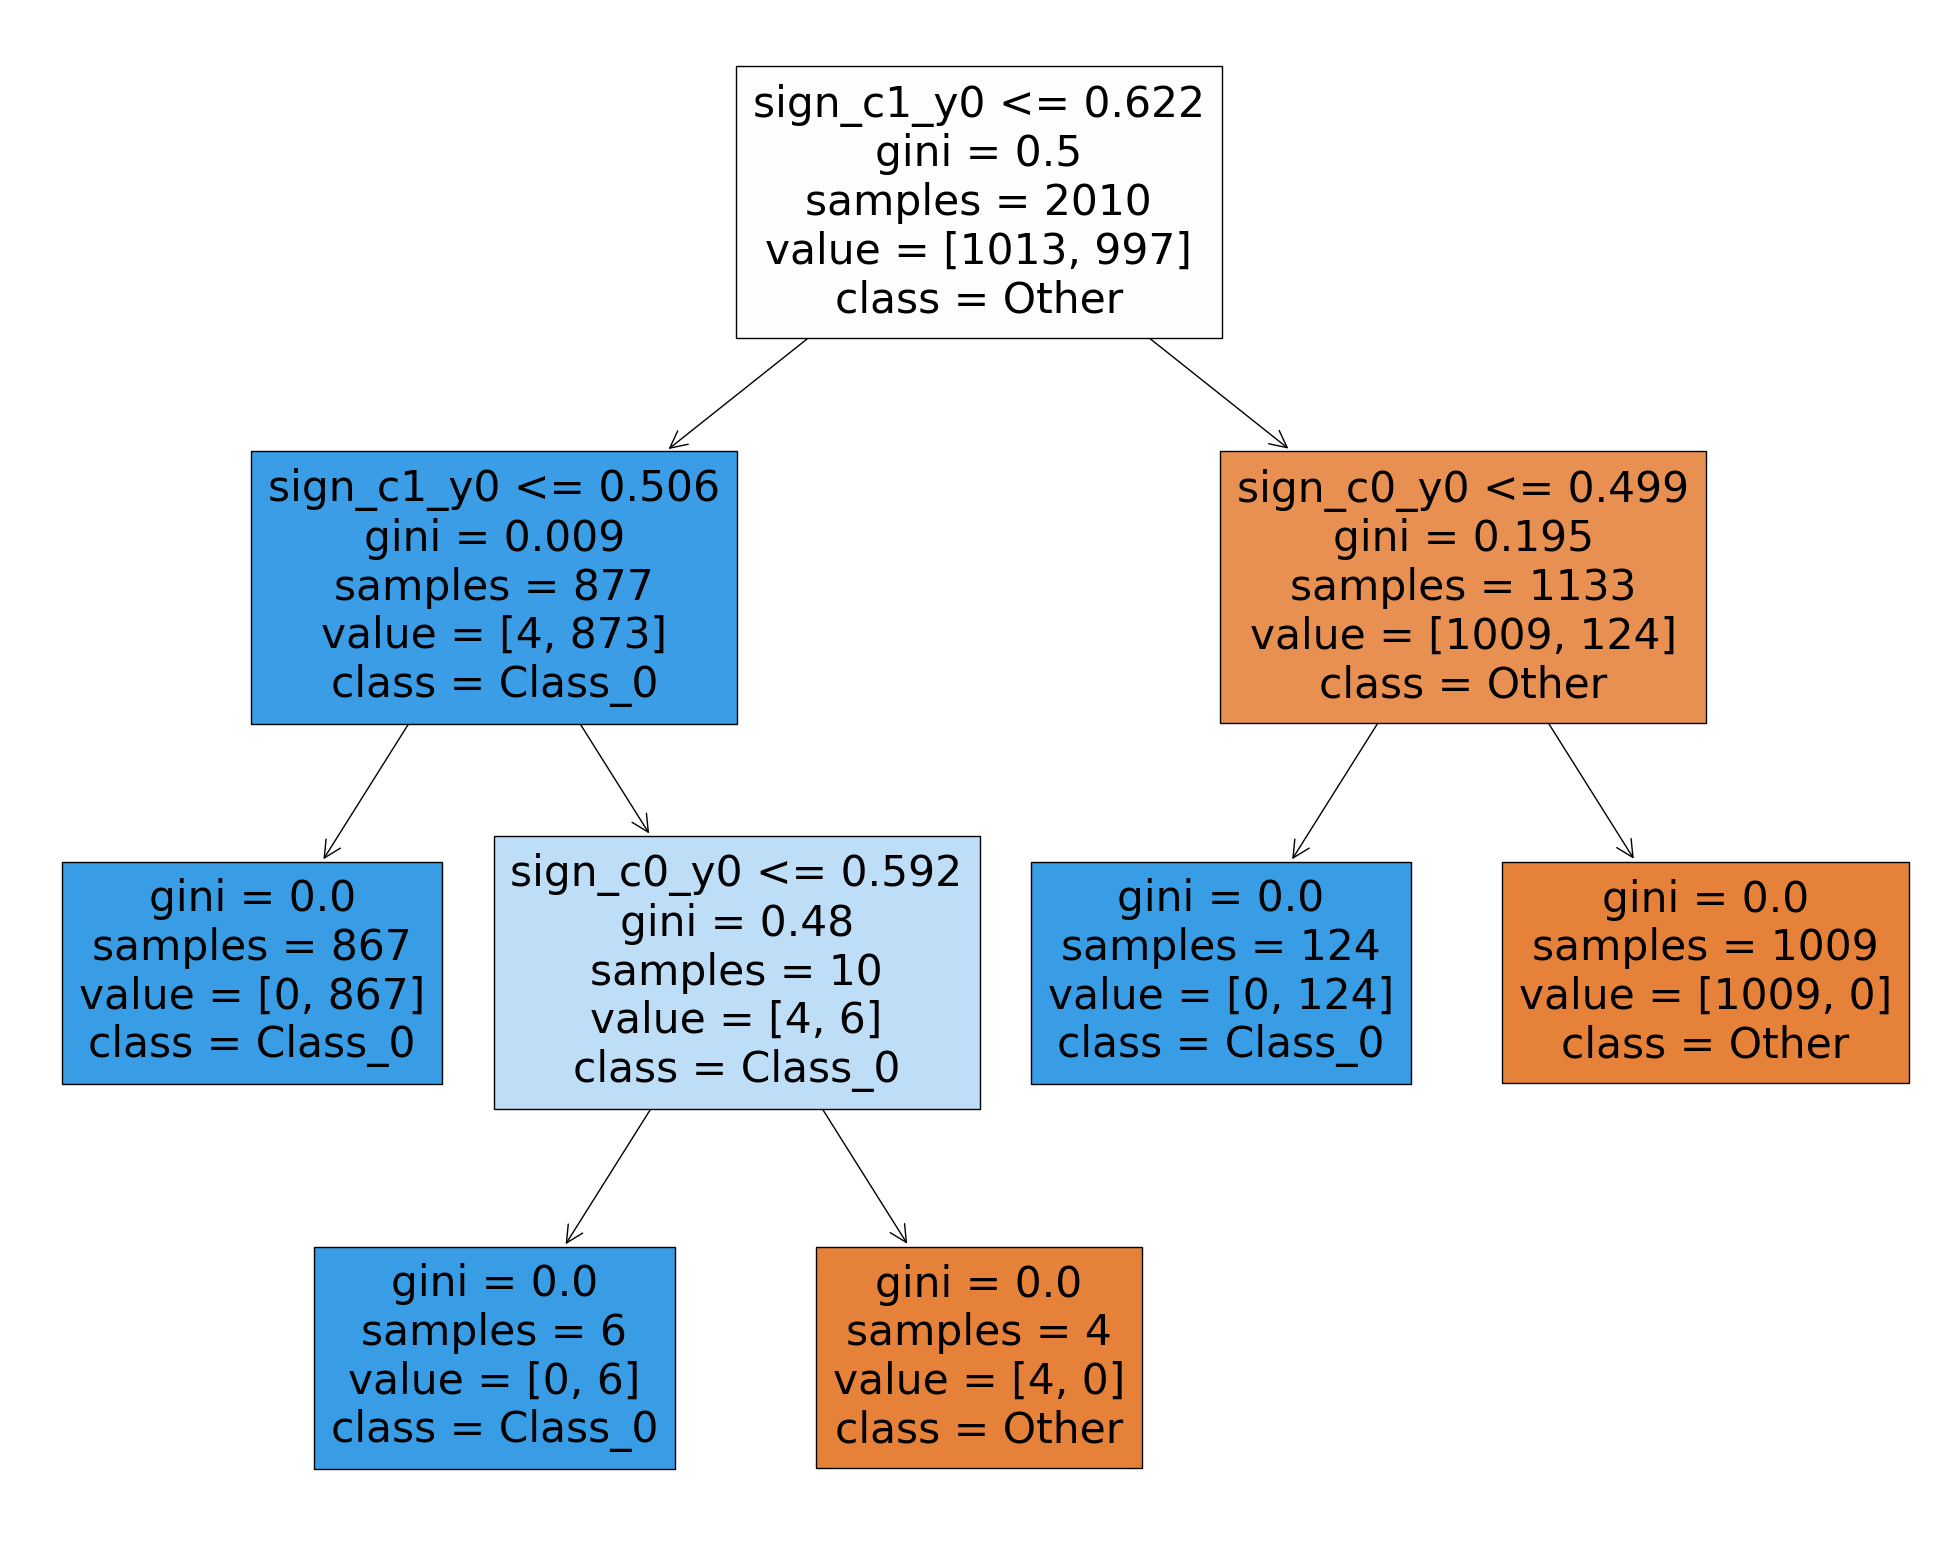

In [34]:
# DT for class 0
clf_funct_0 = explain_with_DT(x_train, concept_encoder, task_predictor, mode='distinct', target_class=0)

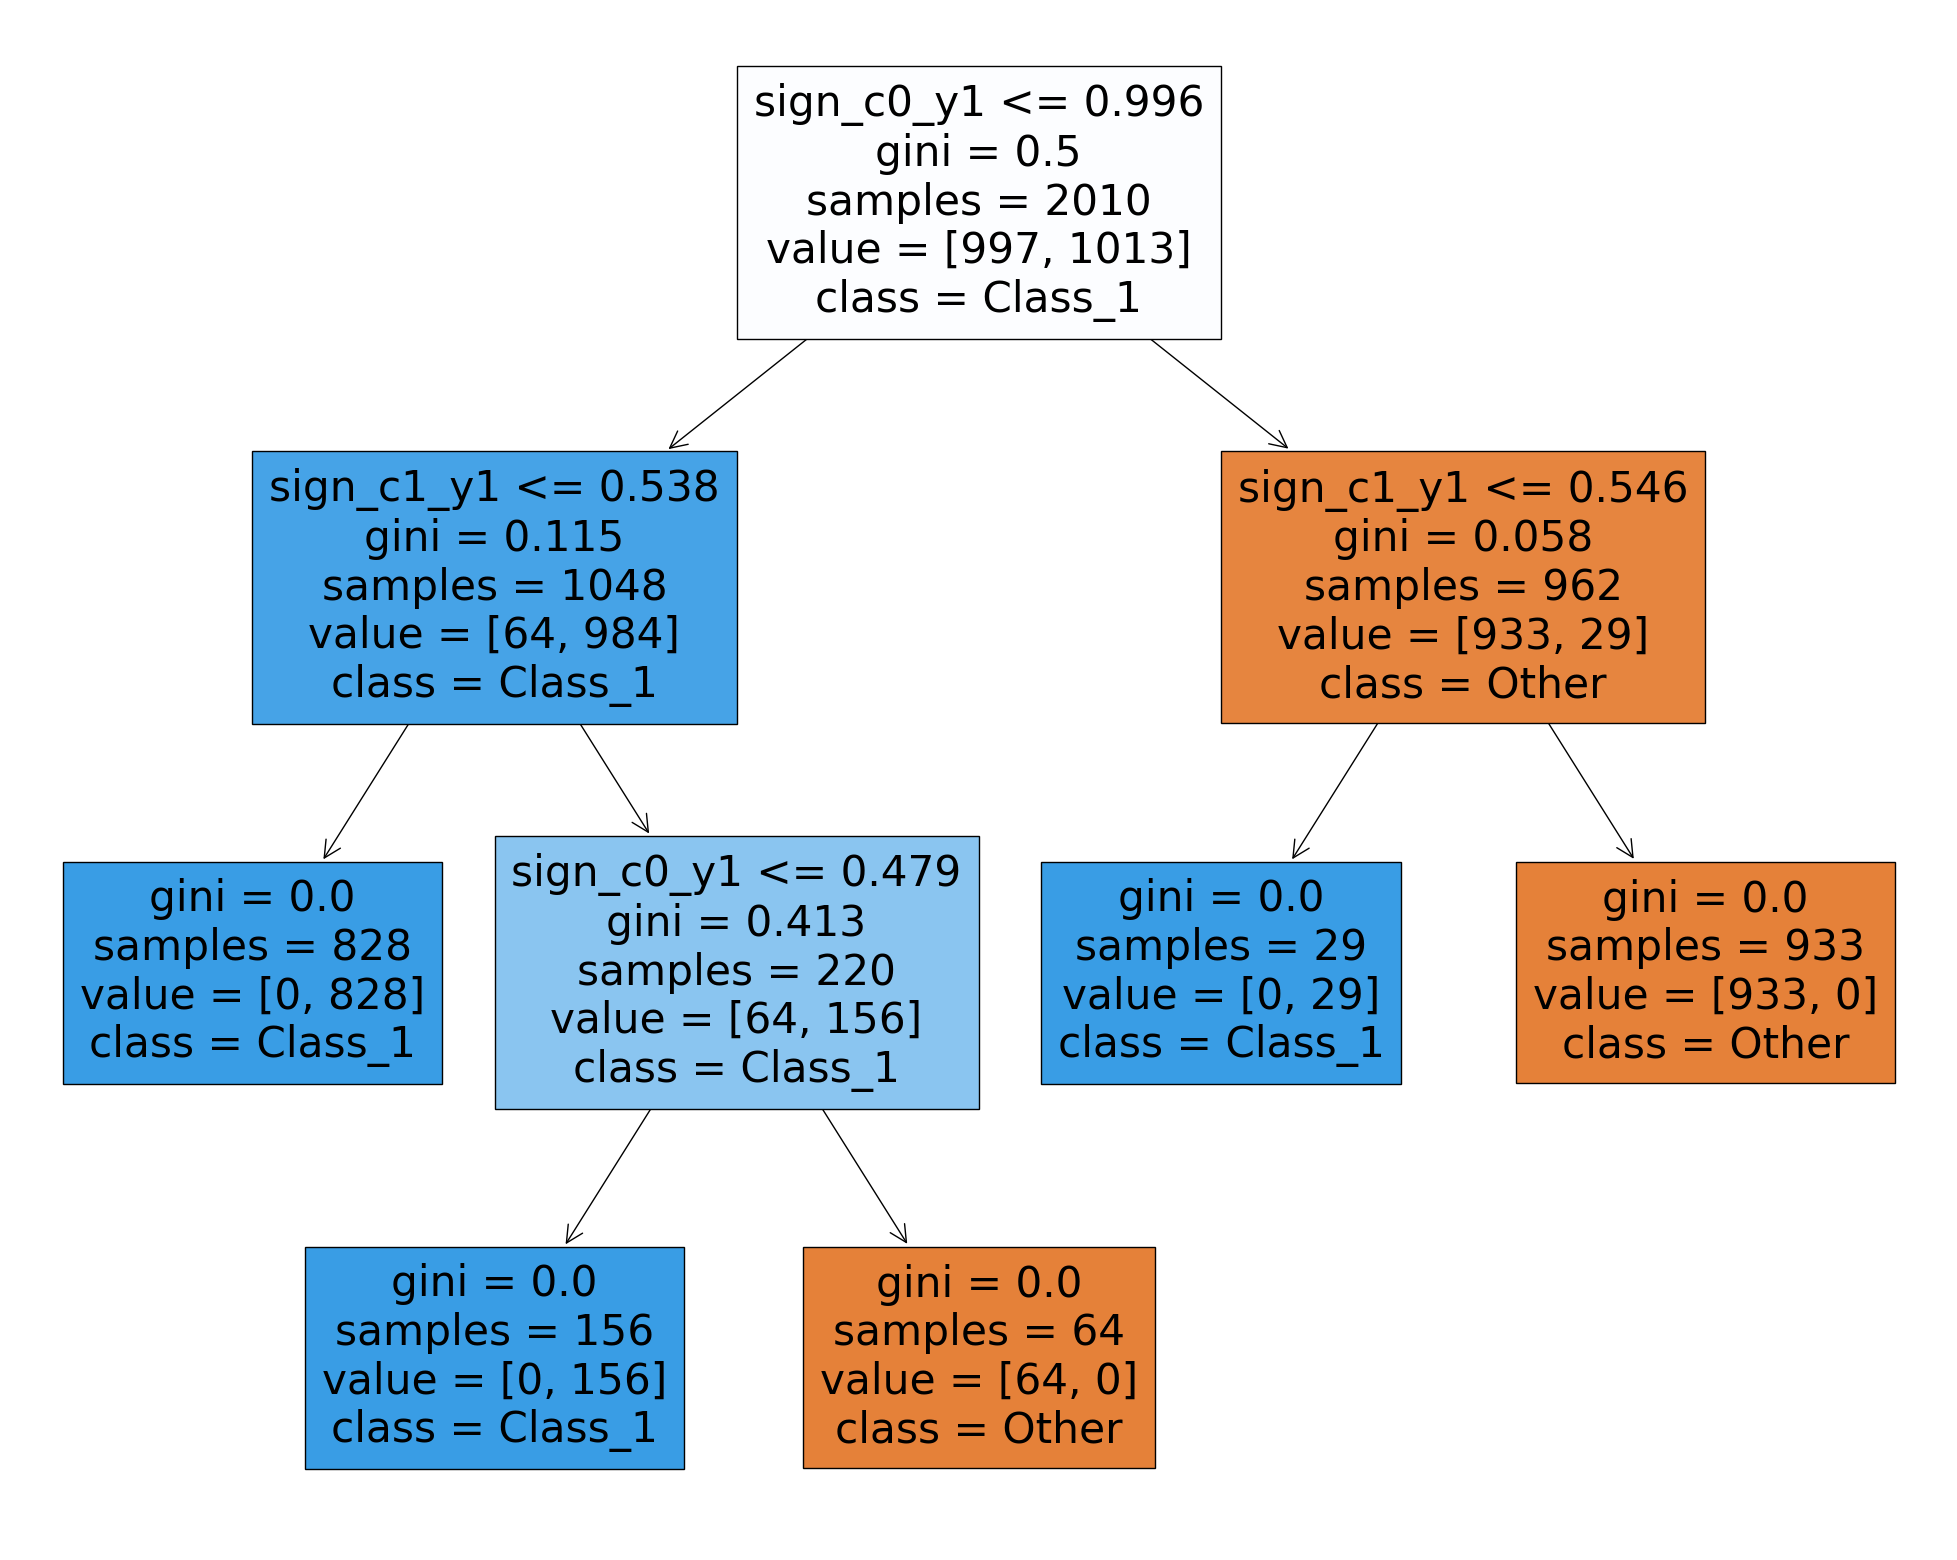

In [35]:
# DT for class 1
clf_funct_1 = explain_with_DT(x_train, concept_encoder, task_predictor, mode='distinct', target_class=1)